In [1]:
!pip -q install lxml

In [2]:
# Version 67
# From https://ungoogled-software.github.io/ungoogled-chromium-binaries/releases/linux_portable/64bit/
!wget -q https://github.com/Eloston/ungoogled-chromium-binaries/releases/download/67.0.3396.87-2/ungoogled-chromium_67.0.3396.87-2_linux.tar.xz
!tar -xf ungoogled-chromium_67.0.3396.87-2_linux.tar.xz

# From https://chromedriver.storage.googleapis.com/index.html
!wget -q https://chromedriver.storage.googleapis.com/2.41/chromedriver_linux64.zip
!unzip -o chromedriver_linux64.zip -d ./ungoogled-chromium_67.0.3396.87-1_linux

Archive:  chromedriver_linux64.zip
  inflating: ./ungoogled-chromium_67.0.3396.87-1_linux/chromedriver  


In [9]:
import requests
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import time
import re
import os
from lxml import etree
import pandas as pd
import numpy as np

'''
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--disable-gpu')
chrome_options.add_argument('--incognito')
chrome_options.add_argument('log-level=3')
chrome_options.add_argument("--disable-dev-shm-usage")
chrome_options.add_argument("--no-sandbox")
chrome_driver = os.getcwd() +"/ungoogled-chromium_67.0.3396.87-1_linux/chromedriver"
chrome_options.add_argument("--width=2560")
chrome_options.add_argument("--height=1440")
browser = webdriver.Chrome(options=chrome_options, executable_path=chrome_driver)
'''

'\nchrome_options = webdriver.ChromeOptions()\nchrome_options.add_argument(\'--headless\')\nchrome_options.add_argument(\'--disable-gpu\')\nchrome_options.add_argument(\'--incognito\')\nchrome_options.add_argument(\'log-level=3\')\nchrome_options.add_argument("--disable-dev-shm-usage")\nchrome_options.add_argument("--no-sandbox")\nchrome_driver = os.getcwd() +"/ungoogled-chromium_67.0.3396.87-1_linux/chromedriver"\nchrome_options.add_argument("--width=2560")\nchrome_options.add_argument("--height=1440")\nbrowser = webdriver.Chrome(options=chrome_options, executable_path=chrome_driver)\n'

In [10]:
class recommendation_panel(object):
    """An expectation for checking that the search tag has a minimum number in the document.
    locator - used to find the element
    min_recommendations - Minimum number of tags that should be found
    returns the WebElement once it has the minimum of tags
    """
    def __init__(self, locator, min_recommendations):
        self.locator = locator
        self.minrecmd = min_recommendations

    def __call__(self, driver):
        elements = driver.find_elements(*self.locator)   # Finding the referenced element
        if len(elements) >= self.minrecmd:
            return elements
        else:
            return False

class youtube(object):
    # init variables
    driver = None
    source = None
    element = None
    minrecmd = None
    vid = None
    meta = None
    
    def __init__(self,min_recommendations = 5):
        chrome_options = webdriver.ChromeOptions()
        chrome_options.add_argument('--headless')
        chrome_options.add_argument('--disable-gpu')
        chrome_options.add_argument('--incognito')
        chrome_options.add_argument('log-level=3')
        chrome_options.add_argument("--disable-dev-shm-usage")
        chrome_options.add_argument("--no-sandbox")
        chrome_driver = os.getcwd() +"/ungoogled-chromium_67.0.3396.87-1_linux/chromedriver"
        self.driver = webdriver.Chrome(options=chrome_options, executable_path=chrome_driver)
        self.minrecmd = min_recommendations
        
    def fetch(self, vid):
        # Ask browser to go to url
        #self.driver.execute_script("window.open('');")
        #self.driver.switch_to.window(self.driver.window_handles[1])
        self.vid = vid
        self.driver.set_window_position(0, 0)
        self.driver.set_window_size(1968, 1000)
        self.driver.get(f'https://www.youtube.com/watch?v={vid}')
        #self.driver.switch_to.window(driver.window_handles[1])
        # Wait until we have the recommendation panel
        self.element = WebDriverWait(self.driver, 10).until(
            recommendation_panel((By.CSS_SELECTOR, 'span#video-title'),self.minrecmd))
        self.source = self.driver.page_source
        meta = {}
        meta.update({y:x for x,y in zip([x.get_attribute('content') for x in self.driver.find_elements(By.CSS_SELECTOR,"meta") if x.get_attribute('name') in ['title','description','keywords']],[x.get_attribute('name') for x in self.driver.find_elements(By.CSS_SELECTOR,"meta") if x.get_attribute('name') in ['title','description','keywords']])})
        meta.update({y:x for x,y in zip([x.get_attribute('content') for x in self.driver.find_elements(By.CSS_SELECTOR,"meta") if x.get_attribute('itemprop') in ['duration','interactionCount','datePublished','genre']],[x.get_attribute('itemprop') for x in self.driver.find_elements(By.CSS_SELECTOR,"meta") if x.get_attribute('itemprop') in ['duration','interactionCount','datePublished','genre']])})
        meta.update({'Thumbnail': x for x in [x.get_attribute('content') for x in self.driver.find_elements(By.CSS_SELECTOR,"meta") if x.get_attribute('property') in ['og:image']]})
        # {'property': 'og:image', 'content': 'https://i.ytimg.com/vi/5L31Wbrg7tE/maxresdefault.jpg'},})
        self.meta = meta
        
        #self.getscreenshot()
        #self.driver.close()
        #self.driver.switch_to.window(self.driver.window_handles[0])
        return self.element is not None
    
    def getsource(self):
        if self.source:
            return self.source
        else:
            return 'Empty buffer'#self.driver.page_source
    
    def getscreenshot(self):
        self.driver.save_screenshot('test.png')
        return 'Done'
  
    def getrecommend(self):
        html = etree.HTML(self.source)
        vid = [str.split(x.attrib['href'],'=')[1] for x in html.findall(".//a[@id='thumbnail']") if ('href' in x.attrib.keys())]
        title = [x.attrib['title'] for x in html.findall(".//span[@id='video-title']")]
        channel = [x.text for x in html.findall(".//div[@id='metadata']/div/ytd-channel-name/div/div/yt-formatted-string")]
        views = [x.getchildren()[0].text.replace(' views','') if (len(x.getchildren()) > 1) else x.getchildren()[0].text for x in html.findall(".//div[@id='metadata-line']")]
        created = [x.getchildren()[1].text if (len(x.getchildren()) > 1) else 0 for x in html.findall(".//div[@id='metadata-line']")]
        result = pd.DataFrame(zip(vid,title,channel,views,created),columns=['ID','TITLE','CHANNEL','VIEWS','CREATED'])
        return result
    
    def transcript(self,vid=''):
        if vid == '':
            vid = self.vid
        resp = requests.get(f'https://hierogly.ph/api/transcribe?v={vid}',headers={'User-Agent':'Mozilla/5.0'})
        result = re.sub(r'\[[a-zA-Z0-9,.:\s]*\]','',resp.json()['text'])
        return result


In [11]:
yt = youtube(20)

In [12]:
yt.fetch('5L31Wbrg7tE')

True

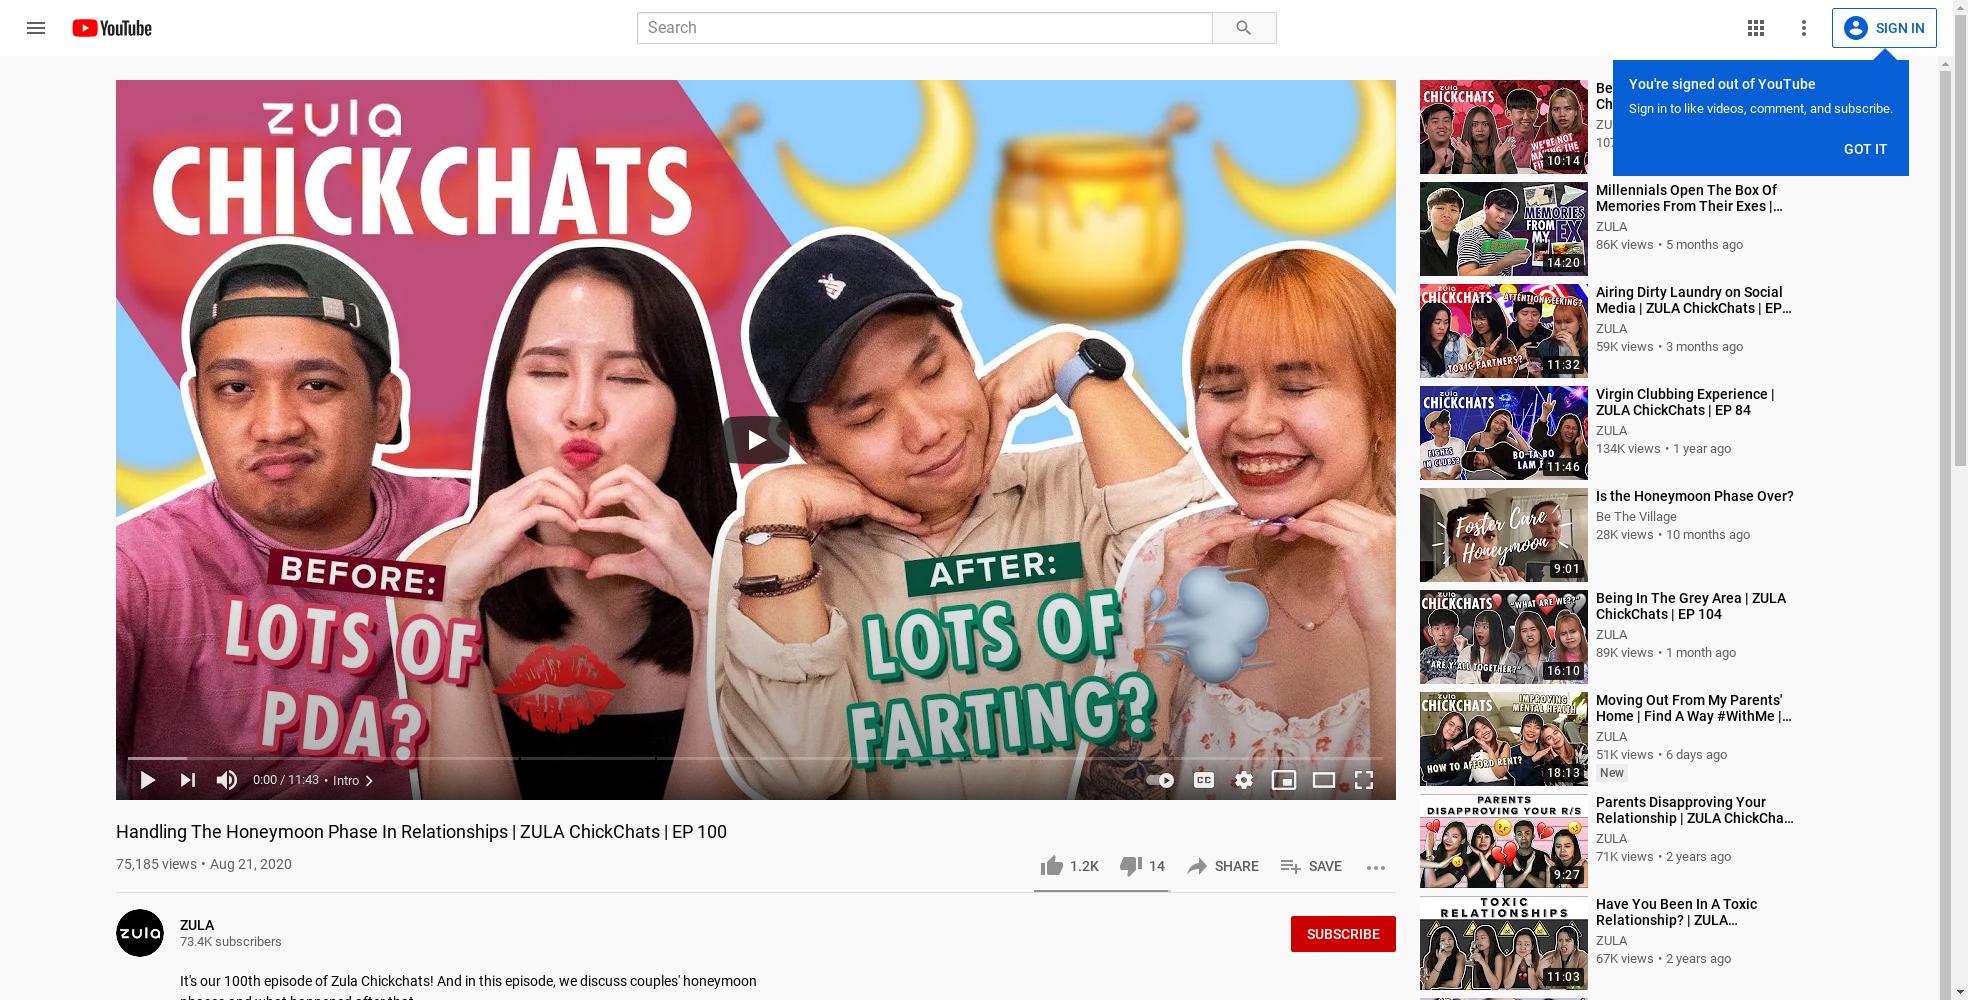

In [10]:
from IPython.display import Image, HTML
yt.getscreenshot()
Image('test.png')

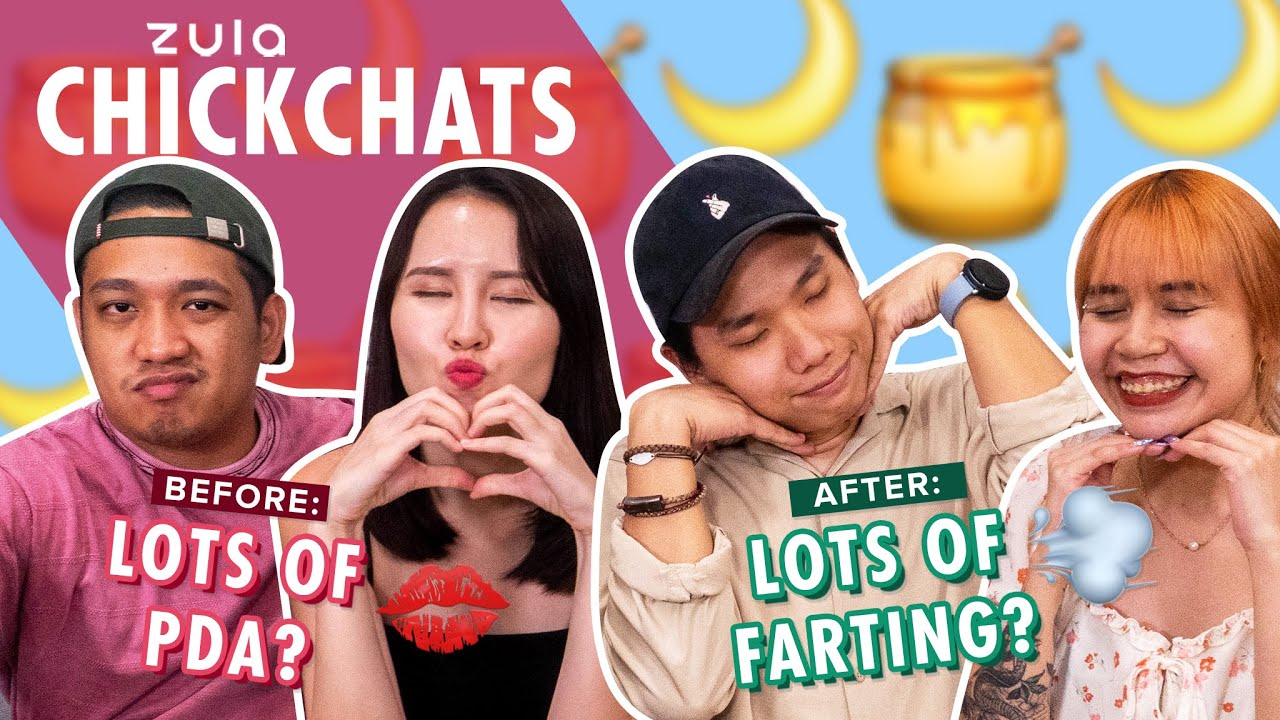

In [17]:
Image('https://i.ytimg.com/vi/5L31Wbrg7tE/maxresdefault.jpg')

In [38]:
yt.getrecommend()

,ID,TITLE,CHANNEL,VIEWS,CREATED
0,BqA-AVabY0E,Being A Passive Dater | ZULA ChickChats | EP 78,ZULA,107K,1 year ago
1,cE0g37750-Y,Millennials Open The Box Of Memories From Thei...,ZULA,86K,5 months ago
2,dJj5-Hbzqe0,Airing Dirty Laundry on Social Media | ZULA Ch...,ZULA,59K,3 months ago
3,O7w94mIogtE,Virgin Clubbing Experience | ZULA ChickChats |...,ZULA,134K,1 year ago
4,eJ-WJssJgdg,Ames Moot Court Competition 2019,Harvard Law School,1.6M,1 year ago
5,rb_adz0tkOw,Being In The Grey Area | ZULA ChickChats | EP 104,ZULA,89K,1 month ago
6,OjvbqVlsLbs,Parents Disapproving Your Relationship | ZULA ...,ZULA,71K,2 years ago
7,Aa-vslh11Dc,Have You Been In A Toxic Relationship? | ZULA ...,ZULA,67K,2 years ago
8,XCp8iEwT1ww,Signs That A Guy Likes You | ZULA ChickChats |...,ZULA,187K,2 years ago
9,oPVte6aMprI,"Deep Focus - Music For Studying, Concentration...",Quiet Quest - Study Music,4.9M,11 months ago


In [18]:
yt.transcript()

"On one of the days um, we were supposed to have a date .... He came to my house like downstairs. Then I no time to draw eyebrows no time to draw anything right. Then we  at the lamp post. There  sure to choose the dimmest lamppost Hi. I ’ m Julian Hi. I ’ m Amanda Hi. I ’ m John Hi. I ’ m Leah and this is Zula ChickChats Hi guys welcome to today. ’ s, episode of Zula ChickChats And today we ’ re gon na be talking about- the honeymoon phase in relationships. We have 3 people over here to share uh- their honeymoon phases in their relationships. So…. The first Can you: why Can you explain what the honeymoon phase is I ...? What do you mean You don, ’ t know I ’ m married. I forgot about it. It ’ s been a long time ago. Okay, so the honeymoon phase, I guess, would be the period before your relationship starts getting serious, All the butterflies, all the romantic gestures, Oh ..., For the first question: maybe we ’ ll, let the audience know for you guys. How long have you been in your rel

In [24]:
# Get Video Properties
{y:x for x,y in zip([x.get_attribute('content') for x in yt.driver.find_elements(By.CSS_SELECTOR,"meta") if x.get_attribute('name') in ['title','description','keywords']],[x.get_attribute('name') for x in yt.driver.find_elements(By.CSS_SELECTOR,"meta") if x.get_attribute('name') in ['title','description','keywords']])}

{'title': 'Handling The Honeymoon Phase In Relationships | ZULA ChickChats | EP 100',
 'description': "It's our 100th episode of Zula Chickchats! And in this episode, we discuss couples' honeymoon phases and what happened after that.Thank you Bifesta for makin...",
 'keywords': 'honeymoon phase, singapore, relationship, pda, being comfortable around partner, boyfriend, girlfriend, bifesta, removing makeup, insecurities, bare face, revealing bare face'}

In [23]:
{y:x for x,y in zip([x.get_attribute('content') for x in yt.driver.find_elements(By.CSS_SELECTOR,"meta") if x.get_attribute('itemprop') in ['duration','interactionCount','datePublished','genre']],[x.get_attribute('itemprop') for x in yt.driver.find_elements(By.CSS_SELECTOR,"meta") if x.get_attribute('itemprop') in ['duration','interactionCount','datePublished','genre']])}

{'duration': 'PT11M44S',
 'interactionCount': '75185',
 'datePublished': '2020-08-21',
 'genre': 'People & Blogs'}

In [15]:
html = etree.HTML(yt.driver.page_source)

In [16]:
[x.attrib for x in html.findall(".//meta")]

[{'http-equiv': 'X-UA-Compatible', 'content': 'IE=edge'},
 {'name': 'theme-color', 'content': 'rgba(255,255,255,0.98)'},
 {'charset': 'UTF-8'},
 {'name': 'title', 'content': 'Handling The Honeymoon Phase In Relationships | ZULA ChickChats | EP 100'},
 {'name': 'description', 'content': "It's our 100th episode of Zula Chickchats! And in this episode, we discuss couples' honeymoon phases and what happened after that.Thank you Bifesta for makin..."},
 {'name': 'keywords', 'content': 'honeymoon phase, singapore, relationship, pda, being comfortable around partner, boyfriend, girlfriend, bifesta, removing makeup, insecurities, bare face, revealing bare face'},
 {'property': 'og:site_name', 'content': 'YouTube'},
 {'property': 'og:url', 'content': 'https://www.youtube.com/watch?v=5L31Wbrg7tE'},
 {'property': 'og:title', 'content': 'Handling The Honeymoon Phase In Relationships | ZULA ChickChats | EP 100'},
 {'property': 'og:image', 'content': 'https://i.ytimg.com/vi/5L31Wbrg7tE/maxresdefault

In [73]:
## Get the IDs from all the anchors
[str.split(x.attrib['href'],'=')[1] for x in html.findall(".//a[@id='thumbnail']") if ('href' in x.attrib.keys())]

['YSFvMJ7Sr9A',
 'nLOvDD9Bs1A&list',
 'xRk3XCYlSno',
 '-H9XpDHhLfM',
 'ikdbeBDAfzg',
 'xgAKV96pFbk',
 'SpSNmPKZOmk',
 'P8Ur0Yi38Sw',
 'i4Nn6Gx2Uv8',
 'xIEhVH7wQw4',
 'GMnwea3nfcg',
 '2zz8kP7Jf94',
 'tsIDyQPHLhs',
 'TZsJvY_FRMY',
 'O1Jkz9AXNTg',
 'YXJ8u16iEVI',
 '96J0qDggwOg',
 '25DOmcjbGAk',
 'o0jefVloo0o',
 'DdnSlF7x9oc']

In [74]:
# Recommended Video Channels
[x.text for x in html.findall(".//div[@id='metadata']/div/ytd-channel-name/div/div/yt-formatted-string")]

['Denpurna Nightcore',
 'YouTube',
 'Cool Nightcore',
 'Nightcore Cloud',
 'Shiro',
 'VvinChan Nightcore',
 'Kuna Unbrella',
 'Nightcore Disciple',
 'Legendary Nightcore',
 'Acoustic Songs Collection',
 'Trending TikTok',
 'Hazzard Overtake',
 'Sachi',
 'Acoustic Songs Collection',
 'JINIE',
 'Zein Nightcore',
 'Cool Nightcore',
 'Nightcore Cloud',
 'Anirose',
 "Xavi's Nightcore Lab"]

In [75]:
# Recommended Video IDs
[str.split(x.attrib['href'],'=')[1] for x in html.findall(".//span[@id='video-title']/../..")]

['YSFvMJ7Sr9A',
 'nLOvDD9Bs1A&list',
 'xRk3XCYlSno',
 '-H9XpDHhLfM',
 'ikdbeBDAfzg',
 'xgAKV96pFbk',
 'SpSNmPKZOmk',
 'P8Ur0Yi38Sw',
 'i4Nn6Gx2Uv8',
 'xIEhVH7wQw4',
 'GMnwea3nfcg',
 '2zz8kP7Jf94',
 'tsIDyQPHLhs',
 'TZsJvY_FRMY',
 'O1Jkz9AXNTg',
 'YXJ8u16iEVI',
 '96J0qDggwOg',
 '25DOmcjbGAk',
 'o0jefVloo0o',
 'DdnSlF7x9oc']

In [76]:
# Recommended Video Titles
[x.attrib['title'] for x in html.findall(".//span[@id='video-title']")]

['Best Nightcore Switching Vocals Mix 2018 ✪ 1 Hour Special ✪',
 'Mix - Nightcore Romantic MIX 2020 - Best Nightcore Switching Vocals Couple Romantic Song Mix',
 'New Nightcore Songs Mix 2020 - Top Nightcore Songs Hour Music 2020 - Best Nightcore Song Remix #6',
 'Best  Love Songs 2020 - Best Hits English  Cover Of Popular Songs /',
 '30 Minutes Nightcore Couple - Switching Vocals Mix (1k Subs Special)',
 'Best Nightcore 2020 - New OPM Nightcore Songs 2020 - New Tagalog Songs 2020 Playlist',
 '❤1Hour Romance Nightcore Mix ❤ #1',
 'Nightcore Opm love songs | New Opm Nightcore 2020',
 'Sad Nightcore 1 Hour Mix! (You must watch) Best Songs!',
 'Top English Acoustic Love Songs 2020 - Greatest Hits Ballad Acoustic Guitar Cover Of Popular Songs',
 'Tik Tok Songs 2020 * TikTok Music 2020 * TikTok Hits 2020 * Tik Tok Hot Trending 2020',
 '★ 30 minutes ♪ Nightcore Couple  Mix #3 💘',
 '30 Minutes Switching Vocals ↬ Nightcore  (Lyrics) (100 Subscribers Special)',
 'Best English Acoustic Love Song

In [80]:
# Get Popularity views
[x.getchildren()[0].text for x in html.findall(".//div[@id='metadata-line']")] # .replace(' views','')
# df['Val'].replace({'K': '*1e3', 'M': '*1e6'}, regex=True).map(pd.eval).astype(int)

['1M views',
 None,
 '358K views',
 '24K views',
 '816K views',
 '1.9K views',
 '303K views',
 '192K views',
 '2.5M views',
 '5M views',
 '336K views',
 '741K views',
 '668 views',
 '2.9M views',
 '137K views',
 '908K views',
 '94K views',
 '1.6M views',
 '368K views',
 '2.5K views']

In [42]:
pd.DataFrame(zip(vid,title,channel,views),columns=['ID','TITLE','CHANNEL','VIEWS'])['VIEWS'].replace({'K': '*1e3', 'M': '*1e6'}, regex=True).map(pd.eval).astype(int)

0      392000
1     8100000
2     1200000
3     1200000
4     3100000
5     4099999
6     8100000
7     3500000
8     2000000
9      335000
10      93000
11     898000
12    1700000
13     362000
14    3000000
15     548000
16    5400000
17    2900000
18    5200000
19      80000
Name: VIEWS, dtype: int64

In [91]:
# Get Created data
[x.getchildren()[1].text if (len(x.getchildren()) > 1) else 'None' for x in html.findall(".//div[@id='metadata-line']")]

['2 years ago',
 'None',
 '4 months ago',
 '3 months ago',
 '3 years ago',
 '2 weeks ago',
 '1 year ago',
 '2 months ago',
 '3 years ago',
 '1 month ago',
 '1 month ago',
 '2 years ago',
 '2 months ago',
 '1 month ago',
 '4 months ago',
 '3 months ago',
 '5 months ago',
 '1 year ago',
 '1 year ago',
 '2 years ago']

In [81]:
vid = [str.split(x.attrib['href'],'=')[1] for x in html.findall(".//a[@id='thumbnail']") if ('href' in x.attrib.keys())]
title = [x.attrib['title'] for x in html.findall(".//span[@id='video-title']")]
channel = [x.text for x in html.findall(".//div[@id='metadata']/div/ytd-channel-name/div/div/yt-formatted-string")]
views = [x.getchildren()[0].text for x in html.findall(".//div[@id='metadata-line']")]
created = [x.getchildren()[1].text for x in html.findall(".//div[@id='metadata-line']")]
pd.DataFrame(zip(vid,title,channel,views,created),columns=['ID','TITLE','CHANNEL','VIEWS','CREATED'])

IndexError: list index out of range

## BTO Transcripts

In [37]:
transcript('cYtSEj1v0ew')

"This is John and Jill. They are about to get married and start a family, but first they have to plan for their future and it's not buying the perfect home. Both John and Jill are working polygraph and the earn a combined monthly salary of $ 4,000. Ideally, they would like to live near their parents in the ground, so many options is easy to get confused now. Do you know what options you have, how welcome number option? 1, a 3-bedroom easy in some balance, a 3-bedroom easy and the balance will cost you about. Seven hundred ninety thousand dollars there's a monthly household income of four thousand dollars. You will be able to take a bank loan of up to two hundred and twenty thousand dollars. Next, let's start by it, you can receive a CPF housing grant releases of up to $ 30,000. This review is four hundred ninety thousand dollars, which has to be paid up front and and resupply suspend for thirty. Nine thousand five hundred dollars has to be paid cash, while the rest can be covered by CP

In [139]:
transcript('rb_adz0tkOw')

"Both of us, we plant a lot of strawberries la on each other's lands. What * screams * Hi, I'm Bolin, I'm Qing, I'm Peps Hi, I'm Leah, and this is Zula ChickChats. Okay, hi guys welcome to today's episode of ChickChats. Why Are you all very nervous? Yes, this is my first time on ChickChats Welcome And today's episode we'll be talking about being in the grey area as much requested from the comments section below. Ah So we hear you okay, we will do this episode for you guys. So my first question to you guys, then, is what happened. Okay, whoever wants can share first la What happened. Bolin, Let's start with Bolin. No Qing should start because she's the new person. Why me? Oh my god? Yes, What happened. I met the person through an app Okay, So we hit off like we talk, then after that move to Telegram. But the thing right we went out for so many times right. The places we go to right were like-, not the kind of place that you and your friends would go to. For example, For example, I need 

In [122]:
transcript('5L31Wbrg7tE')

"On one of the days um, we were supposed to have a date .... He came to my house like downstairs. Then I no time to draw eyebrows no time to draw anything right. Then we [ sat ] at the lamp post. There [, I made ] sure to choose the dimmest lamppost Hi. I ’ m Julian Hi. I ’ m Amanda Hi. I ’ m John Hi. I ’ m Leah and this is Zula ChickChats Hi guys welcome to today. ’ s, episode of Zula ChickChats And today we ’ re gon na be talking about- the honeymoon phase in relationships. We have 3 people over here to share uh- their honeymoon phases in their relationships. So…. The first Can you: why Can you explain what the honeymoon phase is I ...? What do you mean You don, ’ t know I ’ m married. I forgot about it. It ’ s been a long time ago. Okay, so the honeymoon phase, I guess, would be the period before your relationship starts getting serious, All the butterflies, all the romantic gestures, Oh ..., For the first question: maybe we ’ ll, let the audience know for you guys. How long have yo

In [140]:
transcript('cYtSEj1v0ew')

"This is John and Jill. They are about to get married and start a family, but first they have to plan for their future and it's not buying the perfect home. Both John and Jill are working polygraph and the earn a combined monthly salary of $ 4,000. Ideally, they would like to live near their parents in the ground, so many options is easy to get confused now. Do you know what options you have, how welcome number option? 1, a 3-bedroom easy in some balance, a 3-bedroom easy and the balance will cost you about. Seven hundred ninety thousand dollars there's a monthly household income of four thousand dollars. You will be able to take a bank loan of up to two hundred and twenty thousand dollars. Next, let's start by it, you can receive a CPF housing grant releases of up to $ 30,000. This review is four hundred ninety thousand dollars, which has to be paid up front and and resupply suspend for thirty. Nine thousand five hundred dollars has to be paid cash, while the rest can be covered by CP

In [145]:
transcript('mPHGGxZwICI')

"My name is I've been working for about two years. My name is Rob. I'Ve been working for about two years, six years, plus I think five years plus I'm very sure, let's see God my location off just nice kata-kata and they realize okay might as well. We just did I just graduated. Yes, I think two years ago yeah - and I guess it just seemed like a natural information from that February. For the column, one poet a key numbers, a thousand by hello, I'm Hansel - I just graduated from in yet last year, and now I'm doing an internship of jewelry come and your student, your tree, we have been together what six? Yes, I think with us always day. Video, what does the you need to be married before you can apply for the blueblack all controller? I mean you're gon na collect the key. Oh boss, you don't need to be married, like yeah, you can apply first, then you get true or false. It is possible to play pain, zero cash yeah. You can actually go share without paying any cash. It wasn't actually, when w